---
## Data Prep

### Dataset Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from time import time
from src.features import build_features as bf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

sns.set()

---
## Data Preprocessing

In [2]:
features_raw = pd.read_csv('../data/interim/features_raw.csv', index_col='Id')
test_raw = pd.read_csv('../data/raw/test.csv', index_col='Id')
target = pd.read_csv('../data/interim/target_raw.csv', index_col='Id', squeeze=True)

test = test_raw.copy()

In [3]:
features_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
features_raw.shape

(1460, 79)

In [5]:
df_zscore = pd.read_csv('../data/interim/df_zscore.csv', index_col='Id')
outlier_idx = df_zscore[(df_zscore >= 5).any(1)].index
outlier_idx

Int64Index([497, 524, 692, 1183, 1299], dtype='int64', name='Id')

### Handle Outliers

In [6]:
df = features_raw.drop(index=outlier_idx)
target = target.drop(index=outlier_idx)
index = df.index

# Uncomment this line to save the DataFrames
# target.to_csv('../data/interim/target_no_outliers.csv')

In [7]:
df.shape

(1455, 79)

### Assess Missing Data

#### Assess Missing Data in Each Column

In [8]:
df.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1450
MiscFeature     1401
Alley           1364
Fence           1175
FireplaceQu      690
LotFrontage      258
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

#### Assess Missing Data in Each Column

In [9]:
nan_count = df.isna().sum()
nan_count = nan_count[nan_count > 0]
nan_cols = df[nan_count.index].columns
(nan_count / df.shape[0]).sort_values(ascending=False)

PoolQC          0.996564
MiscFeature     0.962887
Alley           0.937457
Fence           0.807560
FireplaceQu     0.474227
LotFrontage     0.177320
GarageYrBlt     0.055670
GarageType      0.055670
GarageFinish    0.055670
GarageQual      0.055670
GarageCond      0.055670
BsmtFinType2    0.026117
BsmtExposure    0.026117
BsmtFinType1    0.025430
BsmtCond        0.025430
BsmtQual        0.025430
MasVnrArea      0.005498
MasVnrType      0.005498
Electrical      0.000687
dtype: float64

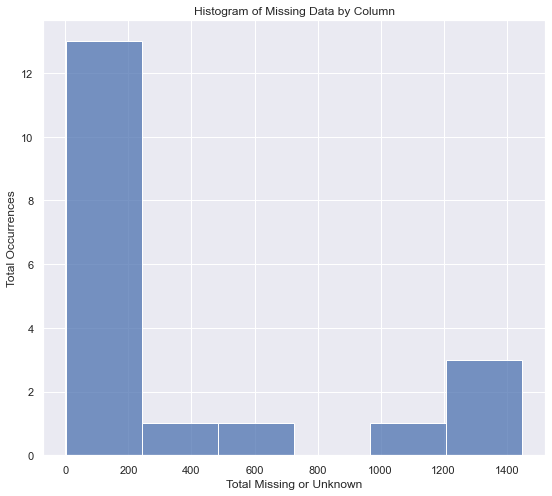

<Figure size 432x288 with 0 Axes>

In [10]:
# Investigate patterns in the amount of missing data in each column.

# plt.rcParams.update({'figure.dpi':100})

plt.figure(figsize=(9, 8))
ax = sns.histplot(nan_count, kde=False)
ax.set_title('Histogram of Missing Data by Column')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyCol_Histogram.svg')

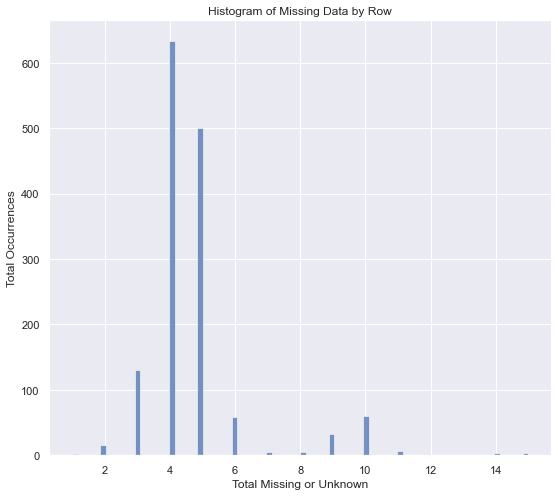

<Figure size 432x288 with 0 Axes>

In [11]:
nan_rows = df.isna().sum(axis=1)
plt.figure(figsize=(9, 8))
ax = sns.histplot(nan_rows, kde=False)
ax.set_title('Histogram of Missing Data by Row')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyRow_Histogram.svg')

#### Assessment Summary

There is a fair amount of missing data in this dataset. Four features in particular (PoolQC, MiscFeature, Alley, Fence) contain >50% missing or unknown values. For PoolQC, we may be able to imply whether or not the home has a pool performing some feature engineering on the PoolArea feature. In addition, several features such as 'GarageArea' indicate the total square footage of a garage (if any) but our dataset does not seem to indicate whether a not a particular home has a garage or not. We'll create features for these. Let's investigate these in turn.

In [12]:
def fill_categorical(val):
    return 1 if val != 'NA' else 0

def fill_numerical(val):
    return 1 if val > 0 else 0

na_cols = ['PoolArea', 'Fence', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu']

df[na_cols] = df[na_cols].fillna('NA')

# Most homes don't have pools. Let's use the value of 'PoolArea' to assign 'NA' to 'PoolQC' if the area == 0

df.loc[df['PoolArea'] == 0, 'PoolQC'] = 'NA' # If no 'PoolArea', (0), then there is no pool 

# Similarly, let's apply the same logic to other features where necessary:

df['HasFence'] = df['Fence'].apply(lambda x: fill_categorical(x))
df['HasAlley'] = df['Alley'].apply(lambda x: fill_categorical(x))
df['HasFireplace'] = df['FireplaceQu'].apply(lambda x: fill_categorical(x))
df['HasPool'] = df['PoolArea'].apply(lambda x: fill_numerical(x))
df['HasGarage'] = df['GarageArea'].apply(lambda x: fill_numerical(x))
df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: fill_numerical(x))

# -------------------------------------------------
# Apply above feature engineering steps on test set
# -------------------------------------------------

test[na_cols] = test[na_cols].fillna('NA')

test.loc[test['PoolArea'] == 0, 'PoolQC'] = 'NA' # If no 'PoolArea', (0), then there is no pool 

test['HasFence'] = test['Fence'].apply(lambda x: fill_categorical(x))
test['HasAlley'] = test['Alley'].apply(lambda x: fill_categorical(x))
test['HasFireplace'] = test['FireplaceQu'].apply(lambda x: fill_categorical(x))
test['HasPool'] = test['PoolArea'].apply(lambda x: fill_numerical(x))
test['HasGarage'] = test['GarageArea'].apply(lambda x: fill_numerical(x))
test['HasBasement'] = test['TotalBsmtSF'].apply(lambda x: fill_numerical(x))

In [13]:
categorical_cols = df.select_dtypes(include=object).columns
numerical_cols = df.select_dtypes(include=np.number).columns

In [14]:
# Perform One-Hot Encoding on our Categorical Data

features_enc = df.copy()
features_onehot_enc = pd.get_dummies(data=features_enc, columns=categorical_cols, dummy_na=True)

# Uncomment this line to export DataFrame
# features_onehot_enc.to_csv('../data/interim/features_onehot_enc.csv')

# Print the number of features after one-hot encoding
encoded = list(features_onehot_enc.columns)
print(f'{len(encoded)} total features after one-hot encoding.')

# Uncomment the following line to see the encoded feature names
# print(encoded)

# -------------------------------------------------
# Apply above feature engineering steps on test set
# -------------------------------------------------

test_enc = test.copy()
test_onehot_enc = pd.get_dummies(data=test_enc, columns=categorical_cols, dummy_na=True)

# Uncomment this line to export DataFrame
# test_onehot_enc.to_csv('../data/interim/test_onehot_enc.csv')

345 total features after one-hot encoding.
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'HasFence', 'HasAlley', 'HasFireplace', 'HasPool', 'HasGarage', 'HasBasement', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'MSZoning_nan', 'Street_Grvl', 'Street_Pave', 'Street_nan', 'Alley_Grvl', 'Alley_NA', 'Alley_Pave', 'Alley_nan', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LotShape_nan', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LandContour_nan', 'Utilitie

In [15]:
imp = IterativeImputer(missing_values=np.nan, random_state=5, max_iter=20)

imputed_arr = imp.fit_transform(features_onehot_enc)
features_imputed = pd.DataFrame(imputed_arr, columns=features_onehot_enc.columns)
features_imputed.index = features_onehot_enc.index

# Uncomment this line to export DataFrame
# features_imputed.to_csv('../data/interim/features_imputed.csv')

# -------------------------------------------------
# Apply above imputation steps on test set
# -------------------------------------------------

imputed_arr_test = imp.fit_transform(test_onehot_enc)
test_imputed = pd.DataFrame(imputed_arr_test, columns=test_onehot_enc.columns)
test_imputed.index = test_onehot_enc.index

In [16]:
def align_dataframes(train_set, test_set):
    if train_set.shape[1] > test_set.shape[1]:
        cols = train_set.columns.difference(test_set.columns)
        df = pd.DataFrame(0, index=train_set.index, columns=cols)
        test_set[df.columns] = df
    elif train_set.shape[1] < test_set.shape[1]:
        cols = test_set.columns.difference(train_set.columns)
        df = pd.DataFrame(0, index=test_set.index, columns=cols)
        train_set[df.columns] = df
        
align_dataframes(features_imputed, test_imputed)

In [17]:
test_imputed = test_imputed.fillna(value=0)

# Uncomment this line to export DataFrame
# test_imputed.to_csv('../data/interim/test_imputed.csv')

### Feature Transformation
#### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We'll need to check the following continuous data features for 'skew'.

- LotFrontage
- LotArea
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal

In [18]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

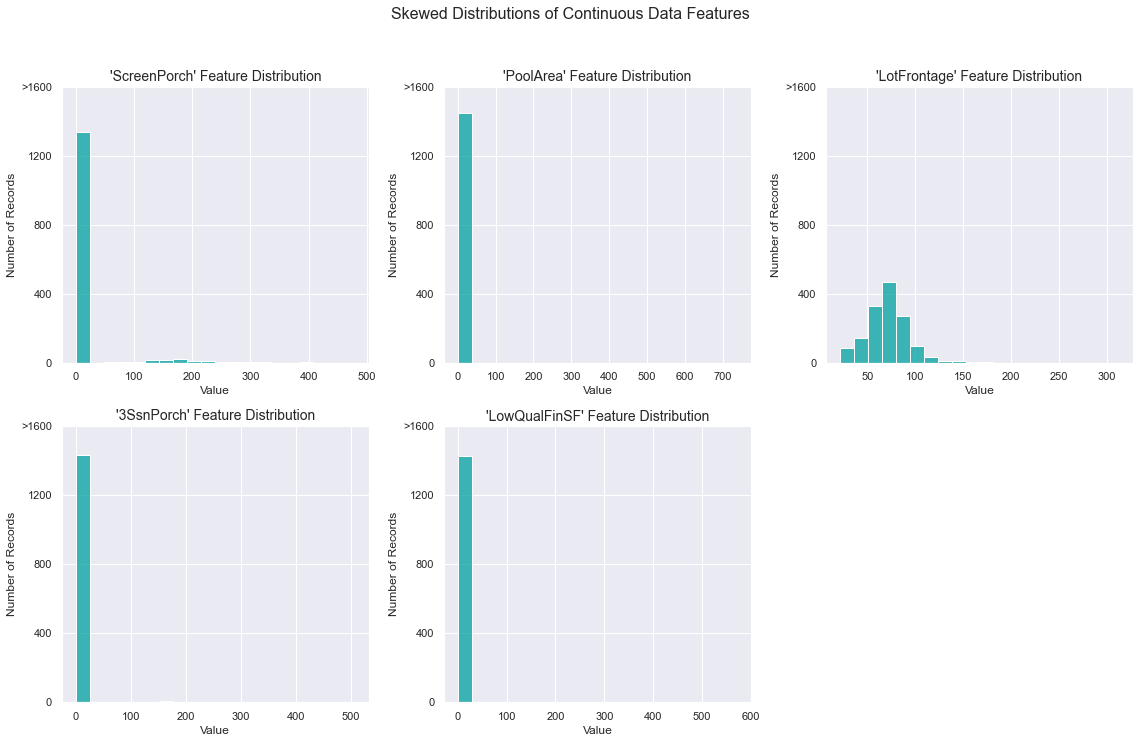

In [19]:
skewed = ['ScreenPorch', 'PoolArea', 'LotFrontage', '3SsnPorch', 'LowQualFinSF']

fig = plt.figure(figsize = (16,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.histplot(features_imputed[feature], bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Skewed_Distributions.svg')

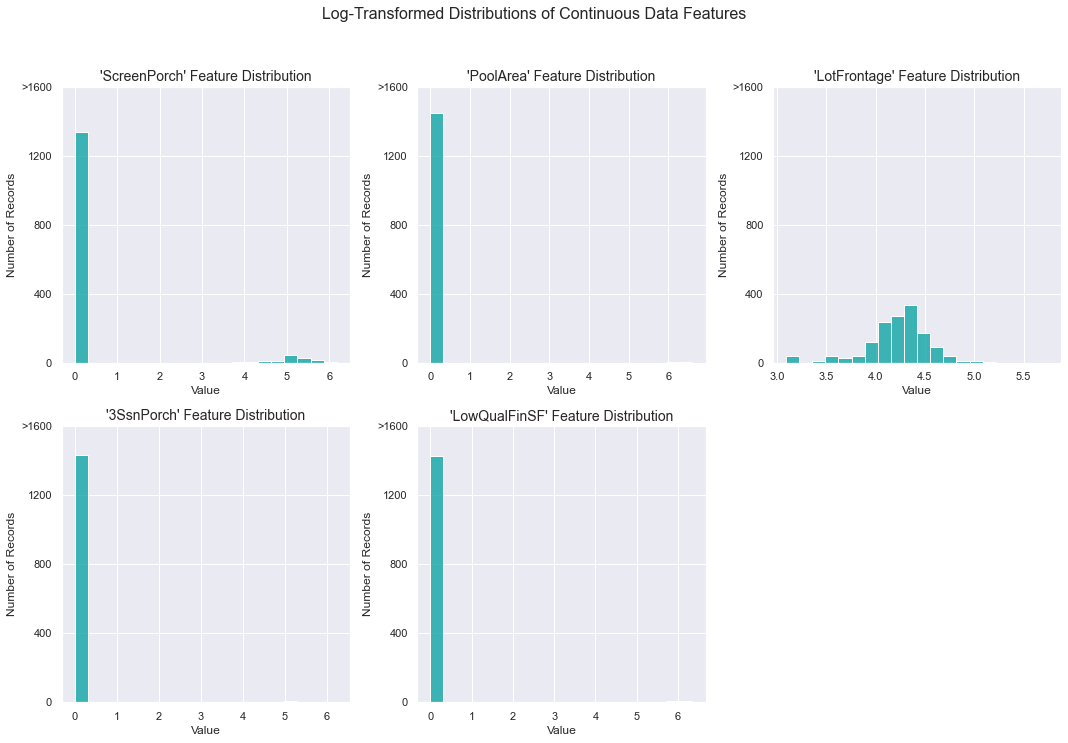

In [20]:
features_log_xformed = pd.DataFrame(data = features_imputed)

# Since the logarithm of 0 is undefined, translate values a small amount to apply the logarithm successfully
features_log_xformed[continuous_cols] = features_imputed[continuous_cols].apply(lambda x: np.log(x + 1))

fig = plt.figure(figsize = (15,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.histplot(features_log_xformed[feature], bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Log-Transformed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Log_Xformed_Distributions.svg')

# -------------------------------------------------
# Apply above log transformation steps on test set
# -------------------------------------------------

test_log_xformed = pd.DataFrame(data = test_imputed)

# Since the logarithm of 0 is undefined, translate values a small amount to apply the logarithm successfully
test_log_xformed[continuous_cols] = test_imputed[continuous_cols].apply(lambda x: np.log(x + 1))

We also need to perform a log-transformation on our target variable 'SalePrice' to remove skew.

In [21]:
target_log_xformed = target.transform(np.log)

# Uncomment this line to export DataFrame
# target_log_xformed.to_csv('../data/interim/target_log_xformed.csv')

##### Feature Scaling
#### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. Normalization does, however,  ensure that each feature is treated equally when applying supervised learners.

In [22]:
# Initialize scaler, then apply it to the features
scaler = StandardScaler()
numerical = features_log_xformed.select_dtypes(include=np.number).columns

features_scaled = pd.DataFrame(data = features_log_xformed)
features_scaled[numerical] = scaler.fit_transform(features_log_xformed[numerical])

features_final = features_scaled.copy()

# Uncomment this line to export DataFrame
# features_scaled.to_csv('../data/interim/features_scaled.csv')

# Uncomment this line to export DataFrame
# features_final.to_csv('../data/processed/features_final.csv')

# Show an example of a record with scaling applied
features_final.head()

# -------------------------------------------------
# Apply above feature scaling steps on test set
# -------------------------------------------------

numerical = test_log_xformed.select_dtypes(include=np.number).columns

test_scaled = pd.DataFrame(data = test_log_xformed)
test_scaled[numerical] = scaler.fit_transform(test_log_xformed[numerical])

test_final = test_scaled.copy()

# Uncomment this line to export DataFrame
# test_scaled.to_csv('../data/interim/test_scaled.csv')

# Uncomment this line to export DataFrame
# test_final.to_csv('../data/processed/test_final.csv')